# Neural Networks with Pytorch!
## Create and image classifier

In this assignment you are asked to build and neural network using the PyTorch framework in order to create a classifier!

The dataset that we are going to use is called `Imagenette`; 10.000 images of ten different classes (see below).

NOTE: if you face any computational problems, you can always use the Google Colab to run your experiments.

In [1]:
import os, sys, tarfile
import requests
import shutil

import numpy as np
import torch

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F


In [2]:
# ----- Dataset Splitter -----

def get_samplers(num_train, valid_size):
    use_percentage=True if isinstance(valid_size, float) else False

    # obtain training indices that will be used for validation
    indices = list(range(num_train))
    if use_percentage:
        np.random.shuffle(indices)
        split = int(np.floor(valid_size * num_train))
        train_idx, valid_idx = indices[split:], indices[:split]
    else:
        train_idx, valid_idx = indices[:-valid_size], indices[-valid_size:]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    return train_sampler, valid_sampler


In [3]:
# ----- Imagenette Dataset -----

class Imagenette(Dataset):
    """ Imagenette: Natural Image Dataset
    """
    data_size = (106551014, 205511341)
    resources = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz'
    dir2classes = {'n01440764':'tench', 'n02102040':'English springer', 'n02979186':'cassette player', 
                   'n03000684': 'chain saw', 'n03028079': 'church', 'n03394916': 'French horn', 
                   'n03417042': 'garbage truck', 'n03425413': 'gas pump', 'n03445777': 'golf ball',
                   'n03888257': 'parachute'}

    def __init__(self, root, transform, download, train=True, version='imagenette2-160', **kwargs):
        super().__init__()
        self.root = os.path.join(root, 'imagenette')
        self.transform = transform

        # class attributes
        self.img_dir = ''
        self.samples = []
        self.classes = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # init 
        if download:
            self.download()
        else:
            if not self.dataset_exists():
                raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')
        if train:
            self.img_dir = os.path.join(self.root, 'imagenette2-160', 'train')
        else:
            self.img_dir = os.path.join(self.root, 'imagenette2-160', 'val')

        self.classes, self.class_to_idx, self.idx_to_class = self._find_classes(self.img_dir)
        self.init_dataset()

    @staticmethod
    def extract(tar_url, extract_path='.'):
        tar = tarfile.open(tar_url, 'r')
        for item in tar:
            tar.extract(item, extract_path)
            if item.name.find(".tgz") != -1 or item.name.find(".tar") != -1:
                extract(item.name, "./" + item.name[:item.name.rfind('/')])

    def dataset_exists(self, eps=1):
        """ Check if folder exists via folder size
        """
        if not os.path.exists(self.root):
            return False

        total_size = 0
        for path, dirs, files in os.walk(self.root):
            for f in files:
                fp = os.path.join(path, f)
                total_size += os.path.getsize(fp)

        size1 = int(self.data_size[0]/1000000) # only folder
        size2 = int(self.data_size[1]/1000000) # folder + .tar file
        total_size = int(total_size/1000000)
        return (size1-eps<=total_size<=size1+eps) or (size2-eps<=total_size<=size2+eps)


    def download(self):
        if self.dataset_exists():
            print('Files already downloaded and verified')
            return

        # create root folder
        if not os.path.exists(self.root):
            os.makedirs(self.root)

        # download dataset
        print('{:<2} {:<4}'.format('-->', 'Downloading dataset...'))
        local_filename = os.path.join(self.root, self.resources.split('/')[-1])
        with requests.get(self.resources, stream=True) as r:
            with open(local_filename, 'wb') as f:
                shutil.copyfileobj(r.raw, f)
        print('{:<2} {:<4}'.format('-->', 'Downloading Complite!'))

        # extract it
        print('{:<2} {:<4}'.format('-->', 'Extracting imageges...'))
        self.extract(os.path.join(self.root, 'imagenette2-160.tgz'), self.root)
        print('{:<2} {:<4}'.format('-->', 'Extracting Complite!'))

    def _find_classes(self, dir):
        classes = [self.dir2classes[d.name] for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        idx_to_class = {v: k for k, v in class_to_idx.items()}
        return classes, class_to_idx, idx_to_class
    
    def init_dataset(self):
        self.samples = []
        for class_dir in os.listdir(self.img_dir):
            for img in os.listdir(os.path.join(self.img_dir, class_dir)):
                if img.endswith('.JPEG'):
                    self.samples.append((os.path.join(class_dir, img), self.dir2classes[class_dir]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        img_pil = Image.open(os.path.join(self.img_dir, self.samples[index][0])).convert('RGB')
        target  = self.class_to_idx[self.samples[index][1]]

        if self.transform is not None:
            img = self.transform(img_pil)

        return img, target


In [5]:
# ----- Dataloaders -----
def get_dataloaders(data_root='./data/', batch_size=32, resolution=32, valid_size=0.15, download=True, num_workers=6, pin_memory=True, device='cpu'):
    """ Please modify ONLY the batch_size if needed (if you face problem with you computer memory).
    """
    # dataset and data loader kwargs
    kwargs = {} if device=='cpu' else {'num_workers': num_workers, 'pin_memory': pin_memory}
    dataset_kwargs = {'root':data_root, 'download':download}
    loader_kwargs = {'batch_size':batch_size, **kwargs}

    # get data transformation
    train_transform = transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor()
    ])

    valid_transform = transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor()
    ])

    # build datasets
    train_data = Imagenette(train=True,  transform=train_transform, **dataset_kwargs)
    valid_data = Imagenette(train=True,  transform=valid_transform, **dataset_kwargs)
    test_data  = Imagenette(train=False, transform=valid_transform, **dataset_kwargs)

    # define samplers for obtaining training and validation batches
    train_sampler, valid_sampler = get_samplers(len(train_data), valid_size)

    # build dataloaders
    train_loader = DataLoader(train_data, sampler=train_sampler, **loader_kwargs)
    valid_loader = DataLoader(valid_data, sampler=valid_sampler, **loader_kwargs)
    test_loader  = DataLoader(test_data,  shuffle=False, **loader_kwargs)

    return train_loader, valid_loader, test_loader


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified

Train dataset: ~ 8064 images.
Validation dataset: ~ 1472 images.
Test dataset: ~ 3968 images.

Image classes: ['English springer', 'French horn', 'cassette player', 'chain saw', 'church', 'garbage truck', 'gas pump', 'golf ball', 'parachute', 'tench'].



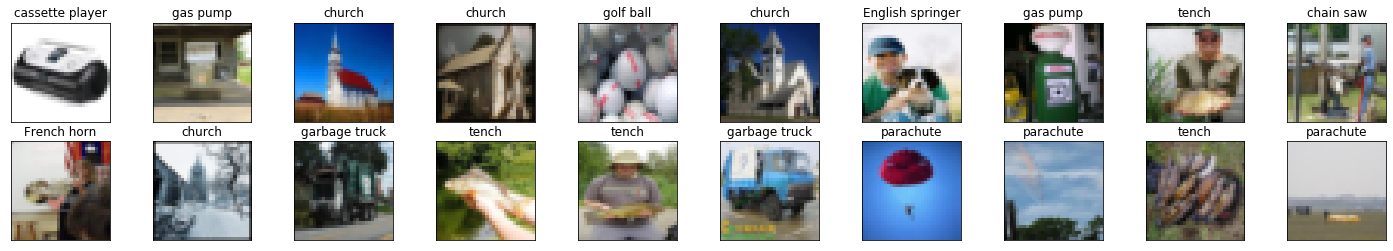

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    """ Helper function to un-normalize and display an image.
        Converts from Tensor image to Numpy for display.
        
        NOTE: Please use `img = img / 2 + 0.5` to
        unnormalize if data is scaled between [-1, 1]. 
    """
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))


# ------------------------------
# -----        TEST        -----
# ------------------------------

# build dataloaders
batch_size = 64
train_loader, valid_loader, test_loader = get_dataloaders(batch_size=batch_size)


# ----- Dataset Specs -----

print('\nTrain dataset: ~ {} images.'.format(len(train_loader)*batch_size))
print('Validation dataset: ~ {} images.'.format(len(valid_loader)*batch_size))
print('Test dataset: ~ {} images.'.format(len(test_loader)*batch_size))

print('\nImage classes: {}.\n'.format(train_loader.dataset.classes))

# ----- Visualisation -----

# obtain one batch of training images
images, labels  = next(iter(train_loader))

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

# display 20 images
n_samples = 20
for idx in np.arange(n_samples):
    ax = fig.add_subplot(n_samples/10, n_samples/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(train_loader.dataset.classes[labels[idx]])


In [7]:
#Fully connected network class
class FCN(nn.Module):

  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(32*32*3, 300)
    self.fc2 = nn.Linear(300, 10)

  def forward(self, x):
    x = x.view(-1,3072)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.softmax(x,dim =1)




In [8]:
#Convolutional Neural Network (CNN)
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, [3,2], stride =1,padding = 1)
        self.pool = nn.MaxPool2d([2,2])
        self.fc1 = nn.Linear(8192, 300)
        self.fc2 = nn.Linear(300, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 8192)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim =1)

In [9]:
#Training, Validate, and Test
def train(net):
  train_average_loss = []
  train_accuracy_avg = []
  valid_average_loss = []
  valid_accuracy_avg = []
  test_accuracy_avg = 0
  for epoch in range(EPOCHS):
    running_loss = 0.0
    count = 0
    correct =0
    total =0
    
    for i, data in enumerate(train_loader,0):
      inputs, labels = data
      output = net(inputs)
      loss = objective(output,labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad() 
      running_loss += loss.item()
      # Accuracy
      _,predicted = torch.max(output,1)
      total +=labels.size(0)
      correct +=(predicted == labels).sum().item()
      count = i
    train_accuracy_avg.append(100 *(correct/total))
    train_average_loss.append(running_loss/(count)) 
    if epoch == 0:
        print('Starting Train loss: %.3f, accuracy: %f' %( running_loss / count, 100 *(correct/total)))
    if epoch == EPOCHS-1:
      print('Last Train loss: %.3f, accuracy: %f' %( running_loss / count, 100 *(correct/total)))   
    running_loss = 0.0
    count = 0
    correct =0
    total =0

    for i, data in enumerate(valid_loader,0):
      inputs, labels = data
      output = net(inputs)
      loss = objective(output,labels)
      optimizer.step()
      optimizer.zero_grad() 
      running_loss += loss.item()
      # Accuracy
      _,predicted = torch.max(output,1)
      total +=labels.size(0)
      correct +=(predicted == labels).sum().item()
      count = i
    valid_accuracy_avg.append(100 *(correct/total))
    valid_average_loss.append(running_loss/(count)) 
    if epoch == 0:
      print('Starting Valid loss: %.3f, accuracy: %f' %( running_loss / count, 100 *(correct/total)))
    if epoch == EPOCHS-1:
      print('Last Valid loss: %.3f, accuracy: %f' %( running_loss / count, 100 *(correct/total)))
  #test final model
  #with torch.no_grad():
  correct =0
  total =0
  test_total = 0
  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      outputs = net(images)
      _,predicted = torch.max(outputs.data,1)
      total += labels.size(0)
      correct +=(predicted == labels).sum().item()

  test_accuracy_avg = 100*(correct/total)
  print("Final test accuracy: %.2f" %(test_accuracy_avg))

  #plot graphs
  #Average Loss
  plt.subplot(2, 1, 1)
  plt.plot(range(len(train_average_loss)), train_average_loss, label ="Training Loss")
  plt.plot(range(len(valid_average_loss)), valid_average_loss, label ="Validation Loss")
  plt.title('Train & Validation average loss over time')
  plt.xlabel('Number of Epoches')
  plt.ylabel('Average Loss')
  #average accuracy
  plt.subplot(2, 1, 2)
  plt.plot(range(len(train_accuracy_avg)), train_accuracy_avg, label ="Training Accuracy")
  plt.plot(range(len(valid_accuracy_avg)), valid_accuracy_avg, label ="Validation Accuracy")
  plt.title('Train & Validation accuracy over time')
  plt.xlabel('Number of Epoches')
  plt.ylabel('Accuracy')

  plt.tight_layout()
  plt.show()

In [ ]:
models =[FCN, CNN]
epochs_number =[10,50,100]
learns = [0.1,0.01,0.001]
for model in models:
  if model == FCN:
    print("Starting Fully connected Network")
  else:
    print("Starting Convolutional Neural Network")
  for i in epochs_number:
    for l in learns:
      print("Epochs: %d, Learning Rate: %.3f" %(i,l))
      net = model()
      # Define objective function
      objective = torch.nn.CrossEntropyLoss()
      #Hyper-Parameters
      EPOCHS = i
      learning_rate = l
      # Define Optimizer
      optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
      train(net)



Starting Fully connected Network
Epochs: 10, Learning Rate: 0.100
